# Grounded Segement Anthing

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks. 
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text. 
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Try 1

## Prepare Environments

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fi87ojw9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fi87ojw9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.


In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GoundingDINO"))

In [ ]:
os.chdir('/content/GroundingDINO')

In [ ]:
!pip install -e .

In [ ]:
! pip install diffusers transformers accelerate scipy safetensors

In [ ]:
!nvidia-smi

In [ ]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

/content/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/content/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


ModuleNotFoundError: ignored

## Load Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [ ]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [ ]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

## Load SAM model

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [ ]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

## Load stable diffusion inpainting models

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda")

## Load demo image

In [ ]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

download_image(image_url, local_image_path)

NameError: ignored

In [ ]:
local_image_path = '../assets/ADE_val_00000132.jpg'

## Run Grounding DINO for detection

In [ ]:
TEXT_PROMPT = "wall"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

In [ ]:
Image.fromarray(image_source)

In [ ]:
Image.fromarray(annotated_frame)

## Run the segmentation model

In [ ]:
# set image
sam_predictor.set_image(image_source)

NameError: ignored

In [ ]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [ ]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


In [ ]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

In [ ]:
Image.fromarray(annotated_frame_with_mask)

NameError: ignored

## Image Inpainting

In [ ]:
image_mask = masks[0][0].cpu().numpy()

NameError: ignored

In [ ]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

NameError: ignored

In [ ]:
image_mask_pil

In [ ]:
# resize for inpaint
image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))

In [ ]:
prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

In [ ]:
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

In [ ]:
image_inpainting

# Try 2

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/devasenan/Documents/projects/mfs/GSAM segmentation tries


## Installing Grounding DINO and SAM

In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 331, done.
remote: Total 331 (delta 0), reused 0 (delta 0), pack-reused 331
Receiving objects: 100% (331/331), 12.36 MiB | 945.00 KiB/s, done.
Resolving deltas: 100% (157/157), done.
/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries/GroundingDINO


In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/ms/33mxkwtn255b353qtr2c5m4r0000gn/T/pip-req-build-9i4q_kln
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/ms/33mxkwtn255b353qtr2c5m4r0000gn/T/pip-req-build-9i4q_kln
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=15e52178a9de3370b4369b807f7355de1bb24ff5612afa52830cbde2a0475b5b
  Stored in directory: /private/var/folders/ms/33mxkwtn255b353qtr2c5m4r0000gn/T/pip-ephem-wheel-cache-nq3nq39u/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment-anything


In [5]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.6.0


In [6]:
!pip install -q roboflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.


## Downloading model weights

In [7]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [8]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries
[Errno 2] No such file or directory: '/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries/weights'
/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries
zsh:1: command not found: wget


In [9]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries/weights/groundingdino_swint_ogc.pth ; exist: False


In [14]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries
[Errno 2] No such file or directory: '/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries/weights'
/Users/devasenan/Documents/projects/mfs/GSAM segmentation tries
zsh:1: command not found: wget


In [11]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Models

In [12]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
SAM_ENCODER_VERSION = "vit_h"

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Load Sample data

In [15]:
f"{HOME}/data"

'/content/data'

In [16]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/content
/content/data


In [40]:
def input_img_and_classes(img, classes, box_thresh=0.35, text_thresh=0.25):
    SOURCE_IMAGE_PATH = f"{HOME}/data/{img}"
    CLASSES = classes
    BOX_TRESHOLD = box_thresh
    TEXT_TRESHOLD = text_thresh

## Zero-Shot Object detection with Grounding DINO

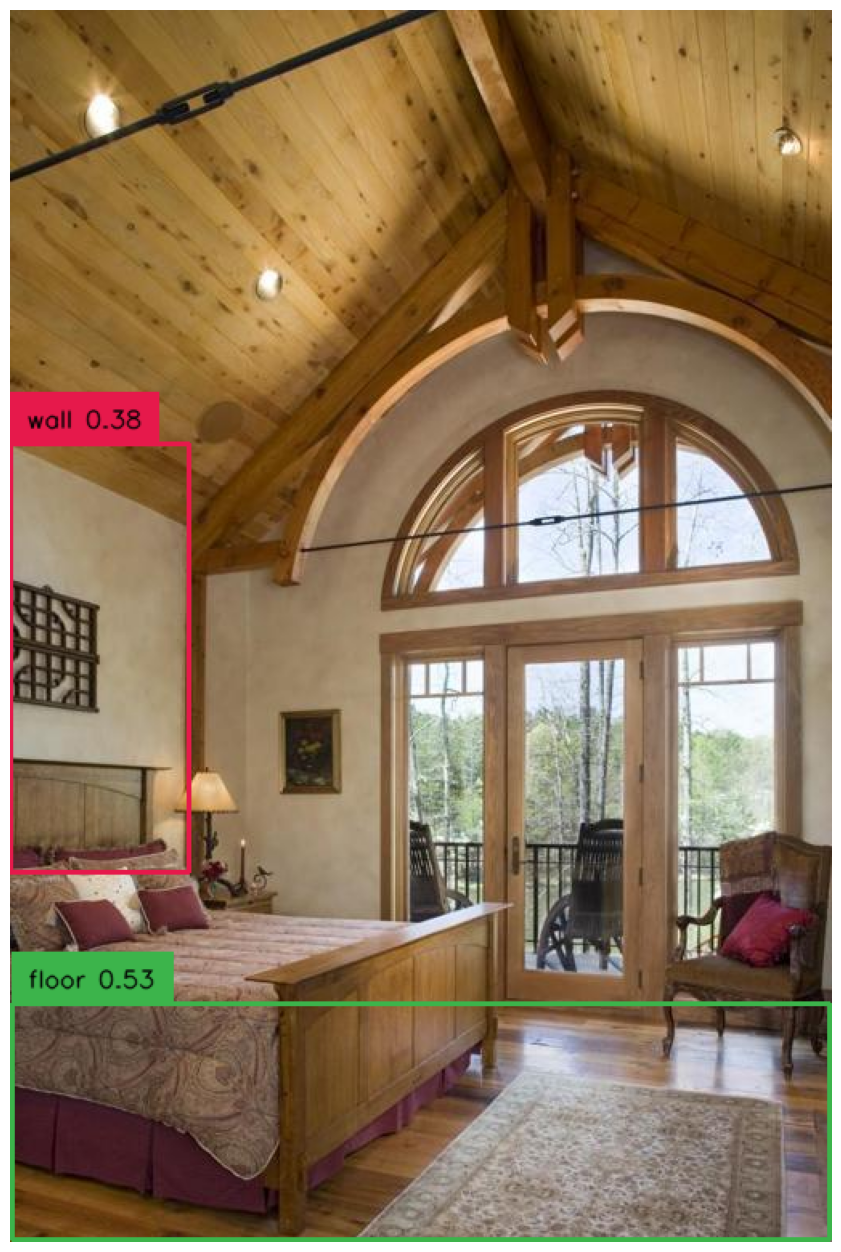

In [28]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Prompting SAM with detected boxes

In [29]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [33]:
def annotate_detections():
    import cv2

    # convert detections to masks
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}" 
        for _, _, confidence, class_id, _ 
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

    %matplotlib inline
    sv.plot_image(annotated_image, (16, 16))

In [32]:
def plot_binary_mask():
    import math

    grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

    titles = [
        CLASSES[class_id]
        for class_id
        in detections.class_id
    ]

    sv.plot_images_grid(
        images=detections.mask,
        titles=titles,
        grid_size=(grid_size_dimension, grid_size_dimension),
        size=(16, 10) 
    )

## Processing time


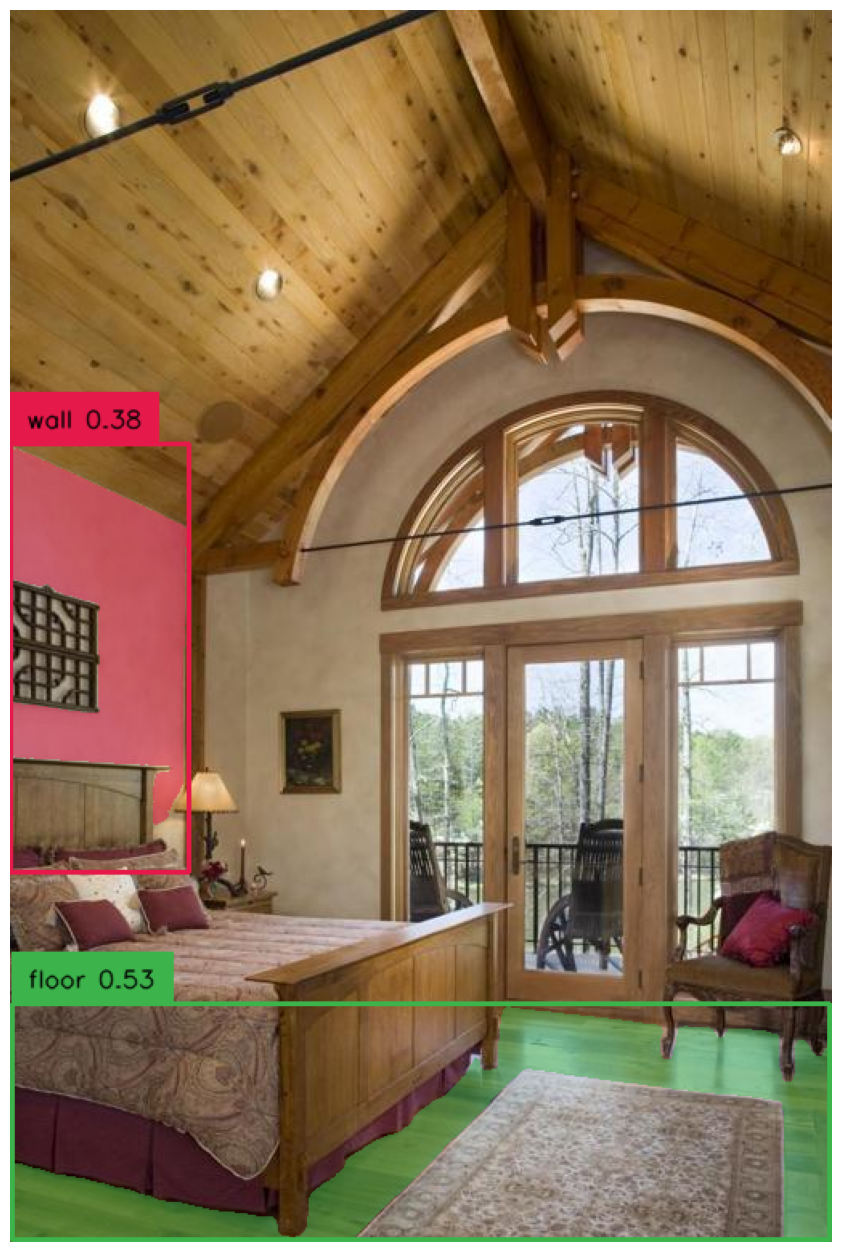

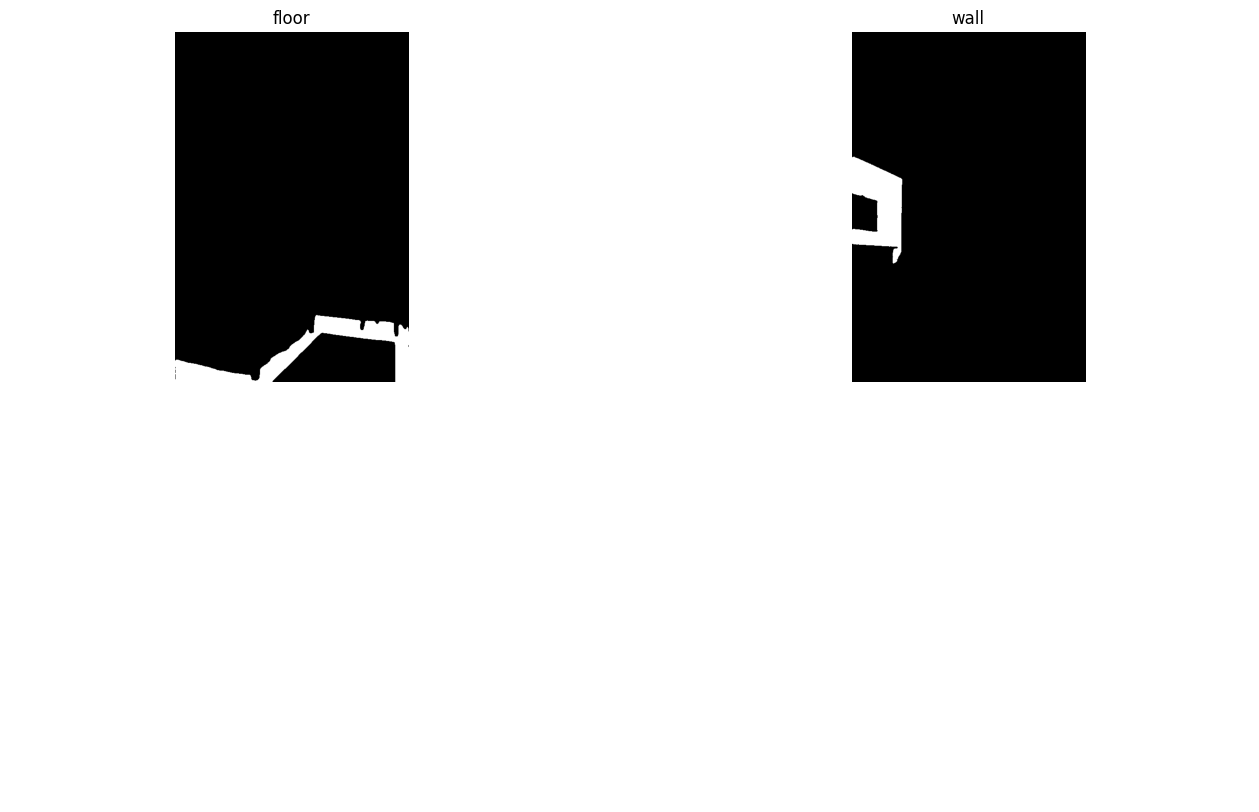

In [44]:
import time

classes = ['wall', 'floor']
img_name = "ADE_val_00000138.jpg"

st = time.time()
input_img_and_classes(img_name, classes)
annotate_detections()
et = time.time()

plot_binary_mask()

In [49]:
print("Execution time: {:.3f}s".format(et-st))

Execution time: 3.024s
